# Cooling System of a FSAE Car


In [2]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *
import math

In [148]:
init= State(tempMotor=80 , tempCooling = 80)
init

,value
tempMotor,80
tempCooling,80


And a `System` object to contain the system parameters.

In [149]:
motor = System(init = init, 
                u = 1000, #heat generated by motor
                p = .994, #density,
                v = 8, #volume
                c = 4178, #specific heat capacity
                dt = 1, #time step
                Tm = 70, #temperature of motor
                h = 2000, #convection coefficient
                T_end = 600
                )
motor

,value
init,tempMotor 80 tempCooling 80 dtype: int64
u,1000
p,0.994
v,8
c,4178
dt,1
Tm,70
h,2000
T_end,600


In [150]:
cooling = System(init = init, 
                p = 1.097, #density,
                v = 119.034, #volume
                c = 1007, #specific heat capacity
                dt = 1, #time steps
                Tc = 50, #temperature of coolin system,
                T_env = 40,
                h = 2500,
                T_end = 600 
                )

cooling

,value
init,tempMotor 80 tempCooling 80 dtype: int64
p,1.097
v,119.034
c,1007
dt,1
Tc,50
T_env,40
h,2500
T_end,600


The `update` function implements Newton's law of cooling.

In [207]:
def updateCooling(state, system1, system2, h):
    unpack(system2)
    Tc = state.tempCooling
    Tc += (-h * (Tc - T_env) + system1.h*(system1.Tm - Tc)) / (p * v * c) * dt
    
    State(tempCooling = Tc)
    return Tc

In [208]:
def updateMotor(state, system1, system2, h):
    unpack(system1)
    T = state.tempMotor
    T += (-h * (T - system2.Tc) + u)/(p * v * c) * dt

    State(tempMotor = T)
    return T

In [165]:
def updateTemp(state, system1, system2):

    unpack(system1)
    Tm = state.tempMotor
    Tm += (-h * (Tm - system2.Tc) + u)/(p * v * c) * dt

    system2.Tc = state.tempCooling
    system2.Tc += (-system2.h * (system2.Tc - system2.T_env) + h*(Tm - system2.Tc)) / (system2.p * system2.v * system2.c) * system2.dt
    
    return State(tempMotor = Tm, tempCooling = system2.Tc)

print(init)

tempMotor      80
tempCooling    80
dtype: int64


Here's how it works.

Now we can run simulations using the same function from the previous chapter.

In [168]:
def run_simulation(system1, system2, update_func1, update_func2):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system1)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[Tm] = init.tempMotor

    ts = linrange(Tm, T_end, dt)
    
    for t in ts:
        frame.loc[t+dt] = updateTemp(frame.loc[t], system1, system2)
    
    system1.results = frame
    system2.results = frame

And here's how it works.

In [169]:
run_simulation(motor, cooling, updateMotor, updateCooling)
motor.results.loc[600]

tempMotor      40.920868
tempCooling    40.415847
Name: 600, dtype: float64

Here's what the results look like.

In [170]:
def run_simulation_cooling(system, updateCooling):
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[Tc] = init.tempCooling
    ts = linrange(Tc, T_end, dt)
    
    for t in ts:
        frame.loc[t+dt] = updateCooling(frame.loc[t], motor, cooling)
    
    system.results = frame

After running the simulation, we can extract the final temperature from the results.

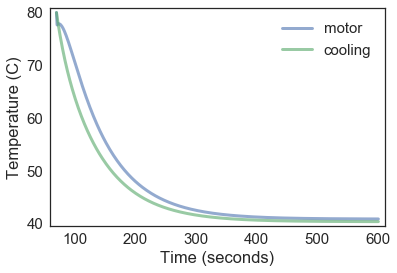

In [171]:
plot(motor.results.tempMotor, label='motor')
plot(cooling.results.tempCooling, label= 'cooling')
decorate(xlabel='Time (seconds)',
         ylabel='Temperature (C)')

In [172]:
sweep = SweepSeries()
for t in linrange(0, 1000, 2):
    temp = updateMotor(init, motor, cooling, t)
    sweep[t] = temp

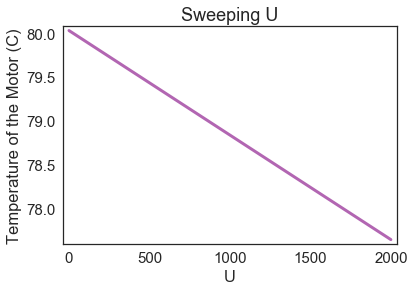

In [219]:
plot(sweep, color='purple')
decorate(xlabel='U',
         ylabel='Temperature of the Motor (C)',
         title = 'Sweeping U',
         legend=False)

In [210]:
sweep = SweepSeries()
for t in linrange(0, 2000, 2):
    temp = updateMotor(init, motor, cooling, t)
    sweep[t] = temp
    

In [214]:
sweep1 = SweepSeries()
for r in linrange(0, 2000, 2):
    temp = updateCooling(init, motor, cooling, r)
    sweep1[r] = temp

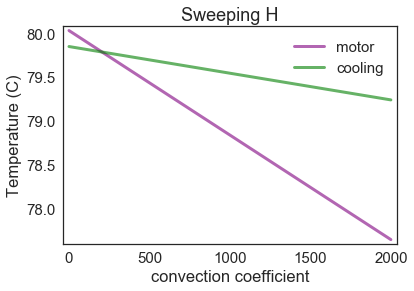

In [217]:
plot(sweep, color='purple', label= 'motor')
plot(sweep1, color='green', label = 'cooling')
decorate(xlabel='convection coefficient',
         ylabel='Temperature (C)',
         title = 'Sweeping H')